### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 09.01.2025 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [30]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [31]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [ ]:
%load_ext autoreload

In [34]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [35]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 966 ms, sys: 0 ns, total: 966 ms
Wall time: 966 ms
Train ROC-AUC 0.9865
Valid ROC-AUC 0.9441
Test ROC-AUC 0.9456


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

In [36]:
results = {'train': list(), 'test': list()}
depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(base_model_params = {'max_depth': depth})
    boosting.fit(x_train, y_train, x_test, y_test)

    results['train'].append(boosting.score(x_train, y_train))
    results['test'].append(boosting.score(x_test, y_test))

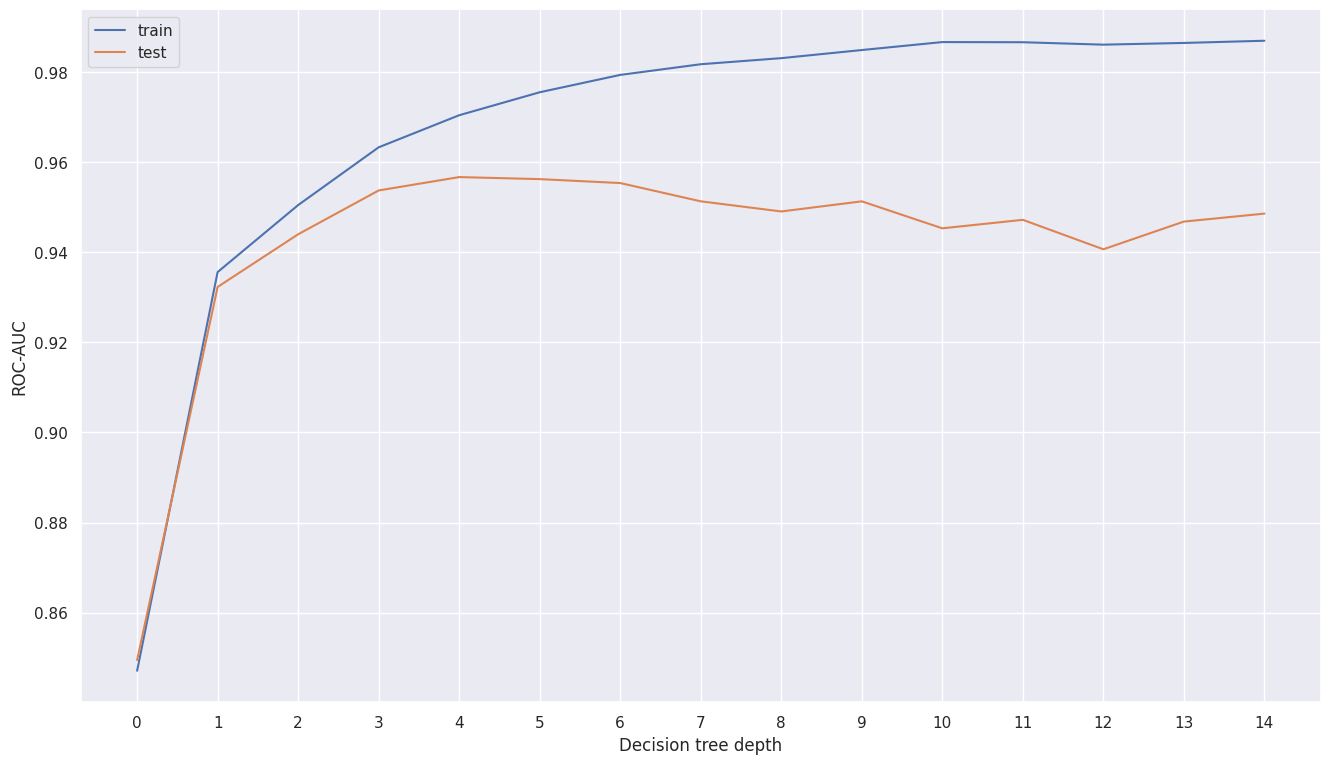

In [37]:
plt.figure(figsize=(16, 9))
plt.plot(results['train'], label='train')
plt.plot(results['test'], label='test')
plt.ylabel('ROC-AUC')
plt.xlabel('Decision tree depth')
plt.xticks(np.arange(0, 15, step=1))
plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

На тестовой выборке лучшее качество имеет модель с глубиной дерева 4 или 5. Затем происходит снижение ROC-AUC. Это происходит из-за того, что при увеличении глубины дерева, модель "подстраивается" под обучающую выборку и происходит переобучение.

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [45]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

def objective(params):
    boosting = Boosting(**params)
    boosting.fit(x_train, y_train, x_test, y_test)
    return -1.0 * boosting.score(x_valid, y_valid)

In [57]:
parameters = {
            'base_model_params' : {
                'max_depth':  hp.choice('max_depth', np.arange(1, 10, dtype=int)),
                'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 3, 4]),
                'min_samples_split': hp.choice('min_samples_split', [1.0, 5, 10, 20])
            },
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'learning_rate': hp.quniform('learning_rate', 0.1, 0.6, 0.05)
        }
 
best = fmin(fn=objective, space=parameters, algo=tpe.suggest, max_evals=10)
print(best)

100%|███████████████████| 10/10 [03:26<00:00, 20.65s/trial, best loss: -0.9677407547212974]
{'learning_rate': 0.4, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 551, 'subsample': 0.8}


In [58]:
best

{'learning_rate': 0.4,
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 551,
 'subsample': 0.8}

In [59]:
best_params = {
    'base_model_params': {
        'max_depth': best['max_depth'],
        'min_samples_leaf': best['min_samples_leaf'],
        'min_samples_split': best['min_samples_split']
    },
    'n_estimators': best['n_estimators'],
    'subsample': best['subsample'],
    'learning_rate': best['learning_rate']
}

In [60]:
best_params

{'base_model_params': {'max_depth': 3,
  'min_samples_leaf': 2,
  'min_samples_split': 3},
 'n_estimators': 551,
 'subsample': 0.8,
 'learning_rate': 0.4}

## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

In [63]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression


boosting = Boosting(**best_params)
boosting.fit(x_train, y_train, x_valid, y_valid)
boost_test = boosting.predict_proba(x_test)[:, 1]

lr = LogisticRegression().fit(x_train, y_train)
lr_test = lr.predict_proba(x_test)[:, 1]

boost_true, boost_pred = calibration_curve(y_test, boost_test, n_bins=20)
lr_true, lr_pred = calibration_curve(y_test, lr_test, n_bins=20)

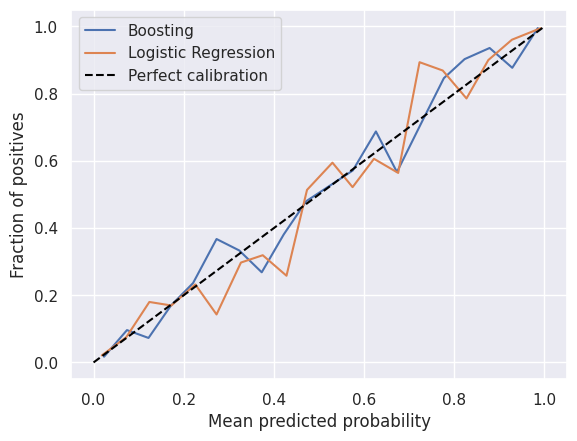

In [64]:
plt.plot(boost_pred, boost_true, label='Boosting')
plt.plot(lr_pred, lr_true, label='Logistic Regression')
plt.plot([0, 1], [0, 1], label='Perfect calibration', linestyle='--', color='black')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

Логистическая регрессия и градиентный бустинг показывают примерно одинаковые результаты на всём диапазоне бинов.

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

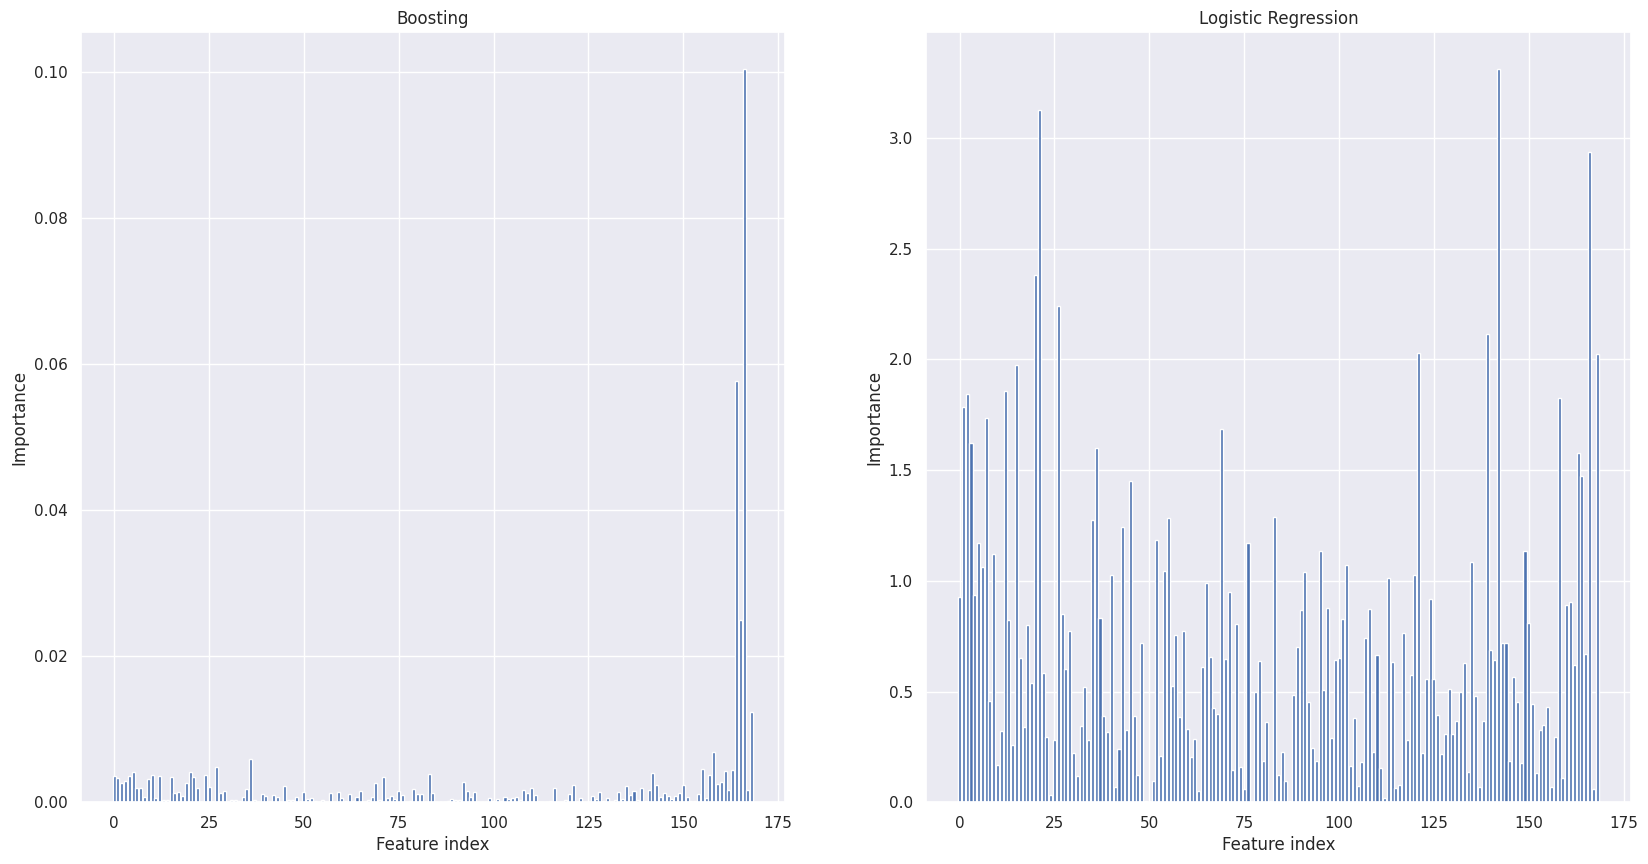

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].bar(np.arange(x_train.shape[1]), boosting.feature_importances_)
ax[0].set_xlabel('Feature index')
ax[0].set_ylabel('Importance')
ax[0].set_title('Boosting')
ax[1].bar(np.arange(x_train.shape[1]), abs(lr.coef_[0]))
ax[1].set_xlabel('Feature index')
ax[1].set_ylabel('Importance')
ax[1].set_title('Logistic Regression')
plt.show()

Для градиентного бустинга выделяются несколько признаков, важность которых существенно больше остальных. Иная картина наблюдается для логистической регрессии: количество признаков, которые выделяются по величине "важности", много больше чем таковое число для градиентного бустинга.

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [128]:
def get_score(threshold):
    model = Boosting(**best_params)
    condition = np.where(boosting.feature_importances_ > threshold)[0]
    model.fit(x_train[:, condition], y_train, x_valid[:, condition], y_valid)
    return model.score(x_test[:, condition], y_test), condition.size

In [137]:
import pandas as pd

thresholds = [0, 0.001, 0.002, 0.02]
df_metrics = pd.DataFrame(columns=['Importance Threshold', 'AUC_ROC', 'Features Count'])

In [138]:
for index, value in enumerate(thresholds):
    data = get_score(value)
    df_metrics.loc[index] = {'Importance Threshold': value,
                             'AUC_ROC': data[0],
                             'Features Count': data[1]}

In [139]:
df_metrics

,Importance Threshold,AUC_ROC,Features Count
0,0.000,0.965944,143
1,0.001,0.966503,72
2,0.002,0.965176,37
3,0.020,0.940303,3


При фильтрации незначительных признаков качество модели растет, есть некая оптимальная точка, но величина AUC_ROC меняетяс в третьем знаке после запятой. При этом, уменьшается количество признаков, использованных при обучении модели, соответсвенно и время, необходимое на обучение, тоже снижается.

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [145]:
from sklearn.metrics import roc_auc_score

meta_x = list()
boosting = Boosting(**best_params)
boosting.fit(x_train, y_train, x_valid, y_valid)

yhat = boosting.predict_proba(x_valid)[:, 1]
yhat = yhat.reshape(len(yhat), 1)

meta_x.append(yhat)
meta_x = np.hstack(meta_x)

lr = LogisticRegression()
lr.fit(meta_x, y_valid)

meta_x = list()
yhat = boosting.predict_proba(x_test)[:, 1]
yhat = yhat.reshape(len(yhat), 1)
meta_x.append(yhat)
meta_x = np.hstack(meta_x)
res_pred = lr.predict(meta_x)

score = roc_auc_score(y_test, res_pred)
print(f'AUC_ROC: {roc_auc_score(y_test, res_pred) :.4f}')

AUC_ROC: 0.8991


Качество модели существенно снизилось.

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [149]:
from catboost import CatBoost, Pool, CatBoostClassifier

train_data = x_train
train_labels = y_train
test_data = catboost_pool = Pool(x_test, y_test)

model = CatBoostClassifier(iterations=2,
                           max_depth=best_['max_depth'],
                           learning_rate=best_['learning_rate'],
                           subsample=best_['subsample'])
model.fit(train_data, train_labels)
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)

print(f'AUC_ROC with CatBoost: {roc_auc_score(preds_class, y_test) :.4f}')

0:	learn: 0.4998927	total: 1.9ms	remaining: 1.9ms
1:	learn: 0.4389466	total: 4.1ms	remaining: 0us
AUC_ROC with CatBoost: 0.7992


Качество модели еще больше снизилось, как по сравнению с блендингом, так и по сравнению с нашей реализацией.

Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
